In [6]:
ns = '10'

cv_name = {
    'ref': 'phi',
    'phi': 'phi',
    'AE': 'deep.node-0',
    'TAE': 'deep.node-0',
    'VDE': 'deep.node-0',
    'DeepTDA': 'deep.node-0',
    'DeepLDA': 'deep.node-0',
    'DeepTICA': 'deep.node-0',
}

FileNotFoundError: [Errno 2] No such file or directory: "./fig/delta_fs_['DeepLDA']_10.pdf"

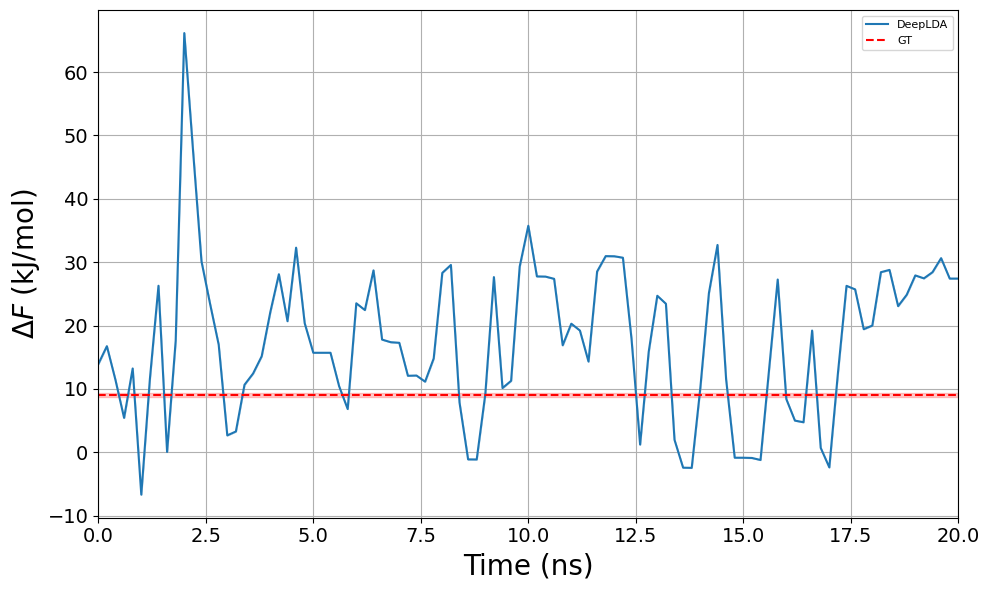

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def calculate_delta_f(phi, free):    
    # Filter data based on conditions
    A = free[phi < 0]
    B = free[(phi > 0) & (phi < 2.2)]
    
    # Calculate free energies
    fesA = -2.49 * np.logaddexp.reduce(-1 / 2.49 * A)
    fesB = -2.49 * np.logaddexp.reduce(-1 / 2.49 * B)
    if np.isnan(fesB-fesA) or np.isinf(fesB-fesA):
        return np.nan
    return fesB - fesA

def load_data(fes_dir, method, i):
    fes_file = os.path.join(fes_dir, 'fes', str(i)+".dat")

    # Load data from the file
    data = np.loadtxt(fes_file, comments='#')
    
    with open(fes_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    phi_idx = keys.index(cv_name[method])
    free_idx = keys.index('file.free')

    phi = data[:, phi_idx]
    free = data[:, free_idx]
    return phi, free

def load_interp(fes_dir, method, i):
    fes_file = os.path.join(fes_dir, 'fes', str(i)+".dat")
    cv_file = os.path.join(fes_dir, "COLVAR")

    # Load data from the file
    data = np.loadtxt(fes_file, comments='#')
    
    with open(fes_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    cv_idx = keys.index(cv_name[method])
    free_idx = keys.index('file.free')

    cv_grid = data[:, cv_idx]
    free_grid = data[:, free_idx]

    # Load data from the file
    data = np.loadtxt(cv_file, comments='#')
    
    with open(cv_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    cv_idx = keys.index(cv_name[method])
    phi_idx = keys.index('phi')

    cv = data[:, cv_idx]
    phi = data[:, phi_idx]

    fes_interp = interp1d(
        cv_grid, 
        free_grid, 
        kind='linear', 
        fill_value="extrapolate"
    )

    free = fes_interp(cv)
    return phi, free
    
def plot(method, ns, date, base_dir):
	plt.figure(figsize=(10, 6))
	times = np.linspace(0,20,101)

	for method,date in zip(methods,dates):
		seed_delta_fs = []
		for seed in range(1):
			delta_fs = []
			for i in range(101):
				fes_dir = os.path.join(base_dir, method, ns, 'log', date, str(seed))
				if method in ['phi','ref']:
					phi, free = load_data(fes_dir, method, i)
				else:
					phi, free = load_interp(fes_dir, method, i)
				delta_f = calculate_delta_f(phi, free)
				delta_fs.append(delta_f)
			seed_delta_fs.append(delta_fs)

	delta_fs = np.array(seed_delta_fs)
	mean_delta_fs = np.nanmean(delta_fs, axis=0)
	std_delta_fs = np.nanstd(delta_fs, axis=0)

	c = colors.pop(0)
	mask = ~np.isnan(mean_delta_fs)
	if mask.sum() == 0:
		plt.plot(times, np.zeros_like(times), label=f'{method}=NaN', alpha=0.0)
	else:
		plt.plot(times[mask], mean_delta_fs[mask], label=f'{method}', color=c)
		plt.fill_between(times[mask], mean_delta_fs[mask] - std_delta_fs[mask], mean_delta_fs[mask] + std_delta_fs[mask], alpha=0.2, color=c)

	plt.xlim(0,20)
	plt.axhline(y=9.04, color='r', linestyle='--', label='GT')
	plt.fill_between(times, 9.04 - 0.33, 9.04 + 0.33, color='r', alpha=0.2)
	plt.xlabel('Time (ns)', fontsize=20, fontweight="medium")
	plt.ylabel(r'$\Delta F$'+' (kJ/mol)', fontsize=20, fontweight="medium")
	plt.legend(fontsize=8, loc='best')
	plt.xticks(fontsize=14)
	plt.yticks(fontsize=14)
	plt.grid(True)
	plt.tight_layout()
	# plt.savefig(f'../figures/delta_fs_over_time_ns={ns}.png', dpi=300, bbox_inches="tight")
	plt.savefig(f'./fig/delta_fs_{methods}_{ns}.pdf', dpi=300, bbox_inches="tight")
	plt.show()
	plt.close()

# methods = ['ref', 'phi', 'AE', 'TAE', 'VDE', 'DeepTDA', 'DeepLDA', 'DeepTICA']
methods = ['DeepLDA']
dates = []
base_dir = f'/home/shpark/prj-mlcv/lib/enhance/simulations/aldp'

for method in methods:
    # date = sorted(os.listdir(os.path.join(base_dir, method, ns, 'log')))[-1]
    date = "0419_150619"
    dates.append(date)
plot(methods, ns, dates, base_dir)